In [40]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.primitives import Sampler

In [41]:
def c_amod15(a):
    """
    Controlled multiplication by a mod 15.
    This is hard-coded for simplicity.
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")
    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [4, 11]:
        U.swap(1, 3)
        U.swap(0, 2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

In [42]:
def phase_estimation(
        controlled_operation: QuantumCircuit,
        psi_prep: QuantumCircuit,
        precision: int,
        draw: bool = False
    ):
    """
    Carry out phase estimation on a simulator.
    Args:
        controlled_operation: The operation to perform phase estimation on,
                              controlled by one qubit.
        psi_prep: Circuit to prepare |ψ>
        precision: Number of counting qubits to use
        draw: Whether to draw the circuit
    Returns:
        float: Best guess for phase of U|ψ>
    """
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)

    # Prepare |ψ>
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)

    # Do phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True,
            )

    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )

    if draw:
        display(qc.draw(output='mpl'))

    qc.measure(control_register, output_register)

    measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return measurement / 2**precision

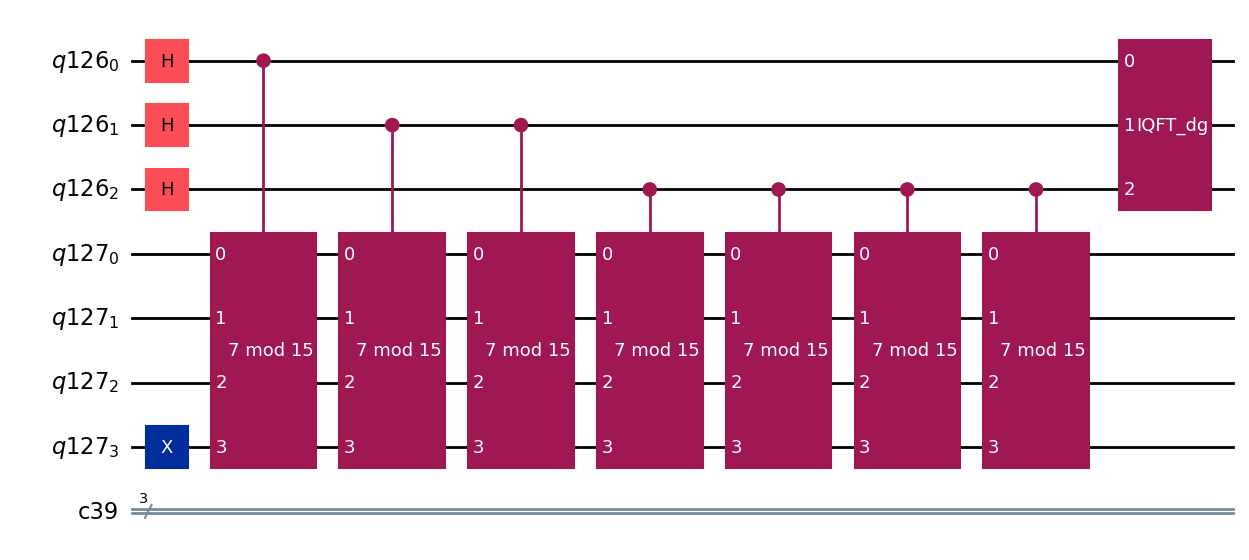

0.25

In [43]:
# Draw Phase estimation circuit
controlled_operation = c_amod15(7)
psi_prep = QuantumCircuit(4)
psi_prep.x(3)

phase_estimation(controlled_operation, psi_prep, 3, draw=True)

In [44]:
psi_prep = QuantumCircuit(4)
psi_prep.x(0)
display(psi_prep.draw())

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────

In [45]:
from fractions import Fraction
from math import gcd

a = 8
N = 21

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amod15(a),
        psi_prep,
        precision=8
    )
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True


Attempt 1

Attempt 2

Attempt 3

Attempt 4
Non-trivial factor found: 7
